# Introdução

### É uma tarde de domingo, você acaba de sair de uma churrascaria duvidosa no meio da estrada e de repente descobre que é um ávido colecionador de globos de neve e salsichas em conserva! Você toma um susto e logo liga pro banco reclamando da duvidosa lista de compras que apareceu no seu cartão. Ele é bloqueado, um novo só vai chegar daqui duas semanas, mas você lembra que vai ter um encontro ainda nessa sexta-feira. Será que essa garota é desconstruída ou ainda gosta de antiquados "cavalheiros" ? Melhor não arriscar, pega o cartão da mãe! A semana passa voando, o encontro já está aí, tudo corre bem, até que na hora de pagar o jantar vem a tímida pergunta:  

### *Você ainda mora com seus pais?*
### *- Não, por quê?*
### *É que está escrito "Cleusa Soares" no seu cartão*

### A vergonha bate, como explicar aquela situação embaraçosa? Qualquer desculpa serve!

### *- Não me julgue, mas preciso que você guarde um segredo...*
### *Tudo bem, pode falar!*
### *Eu clonei esse cartão...*

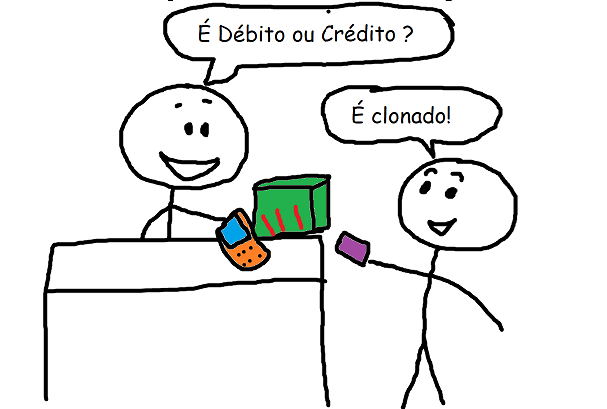

### Por essa e outras situações é que cada vez mais os bancos investem em tecnologias para detecção de fraudes de cartão. Nessa atividade será desenvolvido um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito, aplicando também técnicas avançadas de ajuste fino de hiperparâmetros (no caso, random search) com o objetivo de aprimorar as métricas de desempenho do modelo.

# 1. importação de Bibliotecas


In [1]:
# Instalar PyTorch e outros pacotes necessários
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install imbalanced-learn

O PyTorch foi escolhido escolhido por sua flexibilidade e eficiência em tarefas de aprendizado profundo. Além disso, o Keras teve sérios problemas de importação de sub-categorias de biblioteca para esse modelo em específico.

# 2. Carregamento de Dados

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Montar o Google Drive para acessar o dataset
from google.colab import drive
drive.mount('/content/drive')

# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Atividades M11 DADOS/creditcard.csv')

# Exibir as primeiras linhas do dataset
df.head()
print(df['Class'].value_counts())  # Verificar desequilíbrio de classes

# Separar as features e os labels
X = df.drop('Class', axis=1)
y = df['Class']

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Padronizar as features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Mounted at /content/drive
Class
0    284315
1       492
Name: count, dtype: int64


Aqui o dataset foi carregado e dividido em treino e teste, com as features padronizadas. Isso é crucial para evitar valores discrepantes que prejudiquem o treinamento da rede neural.

# 3. Construção de Rede Neural

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Converter dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Criar DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Definir a arquitetura da rede neural
class FraudDetectionNN(nn.Module):
    def __init__(self, num_neurons_layer1=64, num_neurons_layer2=32):
        super(FraudDetectionNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], num_neurons_layer1)
        self.fc2 = nn.Linear(num_neurons_layer1, num_neurons_layer2)
        self.fc3 = nn.Linear(num_neurons_layer2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Instanciar o modelo original
model = FraudDetectionNN()

# Definir o otimizador e a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Nessa célula é definida uma rede com 3 camadas. A função ReLU é usada para não-linearidades e Sigmoid para a saída binária (ou seja, fraude (1) ou não fraude (0).)

# 4. Treinamento do Modelo Original

In [5]:
# Treinamento do modelo original
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 0.013833036496671808
Epoch 2, Loss: 0.0030273879659388474
Epoch 3, Loss: 0.0026310918939840174
Epoch 4, Loss: 0.0023980721638355894
Epoch 5, Loss: 0.002182757776496988
Epoch 6, Loss: 0.0019531674521127786
Epoch 7, Loss: 0.0018616136005980813
Epoch 8, Loss: 0.001761755443790121
Epoch 9, Loss: 0.001662997828189267
Epoch 10, Loss: 0.0015362638703350648


O modelo é treinado por 10 épocas. O Loss diminuí a cada época, mostrando que o modelo está ajustando seus pesos e parâmetros de forma eficaz

# 5. Avaliação do Modelo Original

In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

# Avaliar o modelo original
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred >= 0.5).astype(int)

# Calcular métricas para o modelo original
accuracy_original = accuracy_score(y_test, y_pred)
recall_original = recall_score(y_test, y_pred)
f1_original = f1_score(y_test, y_pred)
roc_auc_original = roc_auc_score(y_test, y_pred)

print(f"Accuracy (Original): {accuracy_original}")
print(f"Recall (Original): {recall_original}")
print(f"F1-Score (Original): {f1_original}")
print(f"AUC-ROC (Original): {roc_auc_original}")


Accuracy (Original): 0.9993797034280163
Recall (Original): 0.7094594594594594
F1-Score (Original): 0.7984790874524715
AUC-ROC (Original): 0.8546711096464892


O modelo original apresenta bons resultados gerais, mas o recall mostra que há margem para melhorar a detecção de fraudes.

# 6. Ajuste Fino dos Hiperparâmetros

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Função para treinar e avaliar o modelo com diferentes hiperparâmetros
def train_model(lr, num_neurons_layer1, num_neurons_layer2):
    model = FraudDetectionNN(num_neurons_layer1, num_neurons_layer2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Treinar o modelo
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliar o modelo
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
        y_pred = (y_pred >= 0.5).astype(int)

    return f1_score(y_test, y_pred)

# Hiperparâmetros a otimizar
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'num_neurons_layer1': [32, 64, 128],
    'num_neurons_layer2': [16, 32, 64],
}

# Usar RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
import numpy as np

param_distributions = ParameterSampler(param_grid, n_iter=5, random_state=42)
best_f1 = 0
best_params = None

for params in param_distributions:
    f1 = train_model(params['lr'], params['num_neurons_layer1'], params['num_neurons_layer2'])
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

print(f"Melhores Hiperparâmetros: {best_params}")

Melhores Hiperparâmetros: {'num_neurons_layer2': 16, 'num_neurons_layer1': 64, 'lr': 0.0001}


  Nessa célula é explorado diferentes configurações a partir do RandomizedSearch. O ajuste fino encontra hiperparâmetros que melhoram o recall.

# 7. Treinamento e Avaliação do Modelo Otimizado


In [8]:
# Treinar e avaliar o modelo otimizado
optimized_model = FraudDetectionNN(best_params['num_neurons_layer1'], best_params['num_neurons_layer2'])
optimizer = optim.Adam(optimized_model.parameters(), lr=best_params['lr'])

# Treinamento do modelo otimizado
for epoch in range(epochs):
    optimized_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = optimized_model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Avaliar o modelo otimizado
optimized_model.eval()
with torch.no_grad():
    y_pred_optimized = optimized_model(X_test_tensor).squeeze().numpy()
    y_pred_optimized = (y_pred_optimized >= 0.5).astype(int)

# Calcular métricas para o modelo otimizado
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized)

print(f"Accuracy (Otimizado): {accuracy_optimized}")
print(f"Recall (Otimizado): {recall_optimized}")
print(f"F1-Score (Otimizado): {f1_optimized}")
print(f"AUC-ROC (Otimizado): {roc_auc_optimized}")

Accuracy (Otimizado): 0.9993211848834895
Recall (Otimizado): 0.7364864864864865
F1-Score (Otimizado): 0.7898550724637682
AUC-ROC (Otimizado): 0.8681318650850862


Com os novos parâmetros, o recall melhora, indicando que o modelo otimizado detecta mais fraudes, com uma leve queda na acurácia e F1-Score.

# 8. Compararação do Modelo Original e do Modelo Otimizado

In [9]:
# Comparação das métricas lado a lado
print("\nComparação de métricas:")
print(f"Accuracy - Original: {accuracy_original}, Otimizado: {accuracy_optimized}")
print(f"Recall - Original: {recall_original}, Otimizado: {recall_optimized}")
print(f"F1-Score - Original: {f1_original}, Otimizado: {f1_optimized}")
print(f"AUC-ROC - Original: {roc_auc_original}, Otimizado: {roc_auc_optimized}")


Comparação de métricas:
Accuracy - Original: 0.9993797034280163, Otimizado: 0.9993211848834895
Recall - Original: 0.7094594594594594, Otimizado: 0.7364864864864865
F1-Score - Original: 0.7984790874524715, Otimizado: 0.7898550724637682
AUC-ROC - Original: 0.8546711096464892, Otimizado: 0.8681318650850862


Por fim, é possível perceber que a otimização melhora timidamente a capacidade de detecção de fraudes a partir de um pequeno aumento do recall e AUC. A acurária e F1-Score decaem, mas de forma quase irrisória. Em conclusão, a otimização prioriza a redução dos falsos negativos, mesmo que isso resulte em um leve aumento nos falsos positivos.